# DATA

## CAMELS

The Data used to train the neural network was gathered from the Cosmology and Astrophysics with MachinE Learning Simulations (CAMELS). CAMELS contains 6325 cosmological organized in different suits:     

- magnetohydrodynamic:
    - IllustrisTNG
    - SIMBA
    - Astrid
- N-body

Each suit is split into 4 different simulation sets:

- LH (Latin-Hypercube): 1000 simulations with different values of the cosmological and astrophysical parameters which are arranged in a latin-hypercube. The initial conditions of each simulation are also different.
- 1P (1-parameter at a time): 61 simulations where the values of the cosmological and astrophysical parameters are varied one at a time. The initial conditions of each simulation are the same.
- CV (Cosmic Variance): 27 simulations where the cosomological and astrophysical parameters are fixed but the initial conditions vary.
- EX (Extreme): 4 simulations with fixed cosmological parameters but different astrophysical parameters

CAMELS vary 2 cosmological and 4 astrophysical parameters:

- cosmological:
    - $\Omega_m$: Description. range of variation: $0.1 \leq \Omega_m \leq 0.5$
    - $\sigma_8$: Description. range of variation: $0.6 \leq \sigma_8 \leq 1.0$

- astrophysical:
    - $A_{SN1}$: Description. range of variation: $0.25 \leq A_{SN1} \leq 4.0$
    - $A_{SN2}$: Description. range of variation: $0.50 \leq A_{SN2} \leq 2.0$
    - $A_{GN1}$: Description. range of variation: $0.25 \leq A_{GN1} \leq 4.0$
    - $A_{GN2}$: Description. range of variation: $0.50 \leq A_{GN2} \leq 2.0$

Each hydrodynamic simulation evolves 256³ dark matter particles and 256³ gas resolution elements within a periodic comoving volume of 25 h⁻¹Mpc³ from a redshift z= 127 to z=0. During the evolution snapshots of the universe as a function of the redshift are created. In this work just data from the final snapshot, which corresponds to our universe at its current state, were used. We also restrict the data for the purpose of reasonable computation duration to IllustrisTNG-CV simulations. Details zu fof subfindhalos??
Further details on the project and its goals are explained in [quelle: simulation_data.pdf][website].

## Feature Engineering

The data comes in h5py files containing a tremendous amount of information(quelle: https://www.tng-project.org/data/docs/specifications/#sec2
) on the halos and subhalos (galaxies) of the simulated universe. Since we are intereseted in infering the mass of a halo from a few distinct properties of its subhalos we must extract the desired features:
- halo features:
    - Halo mass
    - normalized 3D position
    - normalized 3D velocity
- subhalo features
    - Mass of star & wind particles ?? whyyy
    - Half mass radius
    - normalized 3D position
    - normalized 3D velocity

Since we are interested in only halos containing mass, subhalos that contain a minimum of stellar particles and have mass restrictions are built in. The function "general_tab" does this and outputs a table containing the subhalo features and the halo properties mass, 3D velocity, 3D position and the relevant halo-indices.

In some cases hosting halos close to boundaries can have subhalos on the other extreme of due to the periodic boundary conditions, which occur in the simulation. The function "correct_boundary" fixes this by subtracting or adding a boxlength to the 3D position.

In order to validate the neural net on a dataset, which was not used for training, the data is split into training and validation set, which then are seperated into batches for computing the loss more efficient. The function "split_dataset" deals with this. (umformulieren). 

The routine "create_dataset" builds the fully prepared dataset. For every subhalo contained in a relevant hosting halo (only halos with more than one subhalo) the positions and velocities are changed with their respective relative to the host halo ones. The 3D velocity is then replaced with its magnitude. Together with the global host halo properties number of subhalos and mass a graph (nodes = subhalos) for each hosting halo is created and appended to the dataset. 




In [4]:
#general tab
import h5py
import numpy as np
from Source.constants import *

#--- NORMALIZATION ---#

Nstar_th = 10   # Minimum number of stellar particles required to consider a galaxy
radnorm = 8.    # Ad hoc normalization for half-mass radius
velnorm = 100.  # Ad hoc normalization for velocity. Use velnorm=1. for galcen_frame=1

def general_tab(path):

    # Read hdf5 file
    f = h5py.File(path, 'r')

    # Load subhalo features
    #types = (Gas, Dark Matter, unused, Tracers, Stars & Wind particles, Black holes)Quelle: https://www.tng-project.org/data/docs/specifications/#sec2
    SubhaloPos = f["Subhalo/SubhaloPos"][:]/boxsize
    SubhaloMassType = f["Subhalo/SubhaloMassType"][:,4]
    SubhaloVel = f["Subhalo/SubhaloVel"][:]/velnorm
    SubhaloHalfmassRadType = f["Subhalo/SubhaloHalfmassRadType"][:,4]/radnorm #Comoving radius containing half of the mass of this Subhalo split by Type
    #  just for restriction or classification
    SubhaloLenType = f["Subhalo/SubhaloLenType"][:,4]
    HaloID = np.array(f["Subhalo/SubhaloGrNr"][:], dtype=np.int32)
    
    # Load halo features
    HaloMass = f["Group/Group_M_Crit200"][:]
    GroupPos = f["Group/GroupPos"][:]/boxsize
    GroupVel = f["Group/GroupVel"][:]/velnorm

    # Create general table with subhalo properties
    # Host halo ID, 3D position, stellar mass, number of stellar particles, stellar half-mass radius, 3D velocity
    tab = np.column_stack((HaloID, SubhaloPos, SubhaloMassType, SubhaloLenType, SubhaloHalfmassRadType, SubhaloVel))

    # Restrictions:
    indexes = np.argwhere(HaloMass>0.).reshape(-1)  # Neglect halos with zero mass
    tab = tab[tab[:,4]>0.]                          # restrict to subhalos with mass (stars)
    tab = tab[tab[:,5]>Nstar_th]                    # restrict to subhalos with a minimum of star/wind particles

    tab[:,4] = np.log10(tab[:,4])                   # take the log of the stellar mass

    # Once restricted to a minimum number of stellar particles, remove this feature since it is not observable
    tab = np.delete(tab, 5, 1)
    f.close()
    return tab, HaloMass, GroupPos, GroupVel, indexes

In [5]:
# correct_boundary
# Some halos close to a boundary could have subhalos at the other extreme of the box, due to periodic boundary conditions
# Just add or substract a length boxe in such cases to correct this artifact
def correct_boundary(pos, boxlength=1.):

    for i, pos_i in enumerate(pos):
        for j, coord in enumerate(pos_i):
            if coord > boxlength/2.:
                pos[i,j] -= boxlength
            elif -coord > boxlength/2.:
                pos[i,j] += boxlength

    return pos

In [6]:
# split dataset

from torch_geometric.data import Data, DataLoader
import random

def split_datasets(dataset):

    random.shuffle(dataset)

    num_train = len(dataset)
    split_valid = int(np.floor(valid_size * num_train))
    split_test = split_valid + int(np.floor(test_size * num_train))

    train_dataset = dataset[split_test:]
    valid_dataset = dataset[:split_valid]
    test_dataset = dataset[split_valid:split_test]

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, valid_loader, test_loader

In [7]:
def create_dataset(simsuite = "IllustrisTNG", simset = "CV", n_sims = 27):

    simpath = simpathroot + simsuite + "/"+simset+"_"
    print("Using "+simsuite+" simulation suite, "+simset+" set, "+str(n_sims)+" simulations.")

    dataset = []
    subs = 0    # Number of subhalos

    for sim in range(n_sims):

        path = simpath + str(sim)+"/fof_subhalo_tab_033.hdf5"

        # Load the table of galactic features from a single simulation
        tab, HaloMass, HaloPos, HaloVel, halolist = general_tab(path)

        # For each halo in the simulation:
        for ind in halolist:

            # Select subhalos within a halo with index ind
            tab_halo = tab[tab[:,0]==ind][:,1:] #1upwards because we don't need the hosthalo id from original tab

            # Consider only halos with at least one satellite galaxy (besides the central)
            if tab_halo.shape[0]>1:

                # write the positions and velocities as the relative position and velocity to the host halo
                tab_halo[:,0:3] -= HaloPos[ind]
                tab_halo[:,-3:] -= HaloVel[ind]

                # Correct periodic boundary effects
                tab_halo[:,:3] = correct_boundary(tab_halo[:,:3])

                # compute the magnitude of the velocities and create a new table with these values
                subhalovel = np.log10(np.sqrt(np.sum(tab_halo[:,-3:]**2., 1)))  # use this way in case you normalize velocities
                newtab = np.column_stack((tab_halo[:,:-3], subhalovel))

                # Take as global quantities of the halo the number of subhalos and the total stellar mass
                u = np.zeros((1,2), dtype=np.float32)
                u[0,0] = tab_halo.shape[0]  # number of subhalos
                u[0,1] = np.log10(np.sum(10.**tab_halo[:,3])) #global stellar mass

                # Create the graph of the halo
                # x: features (includes positions), pos: positions, u: global quantity
                graph = Data(x=torch.tensor(newtab, dtype=torch.float32), pos=torch.tensor(tab_halo[:,:3], dtype=torch.float32), y=torch.tensor(np.log10(HaloMass[ind]), dtype=torch.float32), u=torch.tensor(u, dtype=torch.float))

                # Update the total number of subhalos
                subs += graph.x.shape[0]

                dataset.append(graph)

    print("Total number of halos", len(dataset), "Total number of subhalos", subs)

    # Number of features
    node_features = newtab.shape[1]

    return dataset, node_features

In [38]:
import pandas as pd

pd.DataFrame(columns=["relative_pos_x", "relative_pos_y", "relative_pos_z", "mass", "halfmassRadius", "velocity_magnitude"])

,relative_pos_x,relative_pos_y,relative_pos_z,mass,halfmassRadius,velocity_magnitude


## Visualizing the graph:

creating the dataset (list of graphs each graph represents one halo with its sattelites):

In [37]:
dataset, node_features = create_dataset()

Using IllustrisTNG simulation suite, CV set, 27 simulations.
Total number of halos 2388 Total number of subhalos 11722


choosing the halo with index=ind to visualize:

In [26]:
ind = 1
graph = dataset[ind]

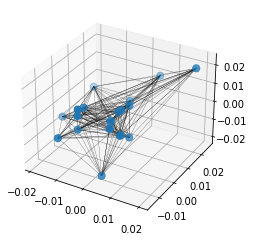

In [28]:
from torch_cluster import radius_graph
import matplotlib.pyplot as plt

k_nn = 0.07
edge_index = radius_graph(graph.pos, r=k_nn) # just plotting the sattelites in radius k_nn

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection ="3d")
pos = graph.x[:,:3]

# Draw lines for each edge
if edge_index is not None:
    for (src, dst) in edge_index.t().tolist():

        src = pos[src].tolist()
        dst = pos[dst].tolist()

        ax.plot([src[0], dst[0]], [src[1], dst[1]], zs=[src[2], dst[2]], linewidth=0.1, color='black')

# Plot nodes
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=50, zorder=1000)